<a href="https://colab.research.google.com/github/l-isaro/fruit-quality-assessment/blob/main/notebook/fruit_quality_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍎 Fruit Quality Classifier Notebook
This notebook trains and evaluates a MobileNetV2 model on fruit quality images.

In [1]:
import sys
import os

# Add the current directory (project root) to the Python path
sys.path.append(os.path.abspath('..'))


In [2]:
from src.preprocessing import get_data_generators
from src.model import build_model, save_model

In [3]:
# Load the data generators
train_gen, val_gen, test_gen = get_data_generators('../data/')
print(f"Train samples: {train_gen.samples}, Validate samples: {val_gen.samples}, Test samples: {test_gen.samples}")
print(f"Train classes: {train_gen.class_indices}")

Found 14724 images belonging to 14 classes.
Found 3150 images belonging to 14 classes.
Found 3170 images belonging to 14 classes.
Train samples: 14724, Validate samples: 3150, Test samples: 3170
Train classes: {'freshapples': 0, 'freshbanana': 1, 'freshcucumber': 2, 'freshokra': 3, 'freshoranges': 4, 'freshpotato': 5, 'freshtomato': 6, 'rottenapples': 7, 'rottenbanana': 8, 'rottencucumber': 9, 'rottenokra': 10, 'rottenoranges': 11, 'rottenpotato': 12, 'rottentomato': 13}


In [4]:
# Build the model
model = build_model(input_shape=(224, 224, 3), num_classes=14)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stopping]
)

Epoch 1/10
461/461 [==============================] - 835s 2s/step - loss: 1.2904 - accuracy: 0.5964 - val_loss: 0.4190 - val_accuracy: 0.8797
Epoch 2/10
461/461 [==============================] - 748s 2s/step - loss: 0.5444 - accuracy: 0.8198 - val_loss: 0.2662 - val_accuracy: 0.9175
Epoch 3/10
461/461 [==============================] - 736s 2s/step - loss: 0.4010 - accuracy: 0.8637 - val_loss: 0.2033 - val_accuracy: 0.9343
Epoch 4/10
461/461 [==============================] - 761s 2s/step - loss: 0.3259 - accuracy: 0.8883 - val_loss: 0.1674 - val_accuracy: 0.9492
Epoch 5/10
461/461 [==============================] - 833s 2s/step - loss: 0.2820 - accuracy: 0.9041 - val_loss: 0.1528 - val_accuracy: 0.9473
Epoch 6/10
461/461 [==============================] - 821s 2s/step - loss: 0.2549 - accuracy: 0.9139 - val_loss: 0.1395 - val_accuracy: 0.9530
Epoch 7/10
461/461 [==============================] - 823s 2s/step - loss: 0.2282 - accuracy: 0.9220 - val_loss: 0.1236 - val_accuracy: 0.9603

In [6]:
# Save the trained model
save_model(model, 'models/fruit_model.h5')

## 📊 Model Evaluation
Evaluate the model on test data using classification metrics.

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on validation set
y_true_val = []
y_pred_val = []
for x_batch, y_batch in val_gen:
    y_pred_probs = model.predict(x_batch, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_batch, axis=1)
    y_true_val.extend(y_true)
    y_pred_val.extend(y_pred)
    if len(y_true_val) >= val_gen.samples:
        break

y_true_val = np.array(y_true_val)
y_pred_val = np.array(y_pred_val)
class_labels = list(val_gen.class_indices.keys())
print("Validation Report:")
print(classification_report(y_true_val, y_pred_val, target_names=class_labels))

# Evaluate on test set
y_true_test = []
y_pred_test = []
for x_batch, y_batch in test_gen:
    y_pred_probs = model.predict(x_batch, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_batch, axis=1)
    y_true_test.extend(y_true)
    y_pred_test.extend(y_pred)
    if len(y_true_test) >= test_gen.samples:
        break

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
print("Test Report:")
print(classification_report(y_true_test, y_pred_test, target_names=class_labels))

Validation Report:
                precision    recall  f1-score   support

   freshapples       0.97      0.98      0.97       363
   freshbanana       1.00      1.00      1.00       370
 freshcucumber       0.87      0.99      0.92        74
     freshokra       0.94      0.95      0.94        95
  freshoranges       0.98      0.94      0.96       219
   freshpotato       0.96      0.89      0.92        80
   freshtomato       0.99      0.93      0.96       278
  rottenapples       0.96      0.98      0.97       487
  rottenbanana       1.00      1.00      1.00       439
rottencucumber       0.90      0.75      0.82        63
    rottenokra       0.81      0.78      0.80        50
 rottenoranges       0.97      0.93      0.95       239
  rottenpotato       0.92      0.97      0.95       120
  rottentomato       0.91      0.99      0.95       273

      accuracy                           0.96      3150
     macro avg       0.94      0.93      0.94      3150
  weighted avg       0.96  

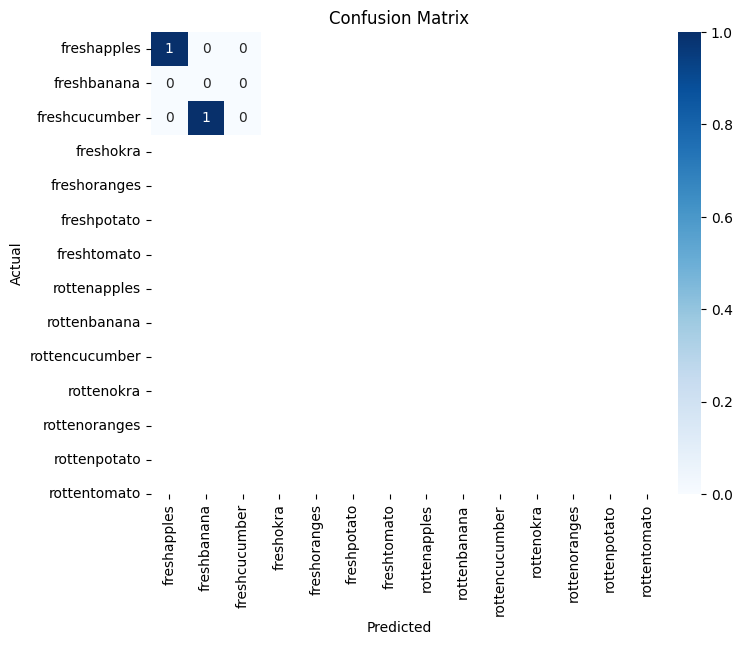

In [9]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()